Import dependencies:


libraries:

    conda install pyculib
    conda install cudatoolkit=7.5
    sudo apt-get install libfftw3-dev
    pip install pyFFTW
    

In [ ]:
import numpy as np
import numexpr as ne

#import os
import importlib

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['font.size'] = 9

#import astropy.io
import astropy.units as u

import poppy
import pyfftw
import logging
logging.basicConfig(format='%(levelname)s:%(message)s',
                    level=logging.WARN)



%matplotlib inline


In [ ]:

poppy.accel_math.benchmark_fft(npix=8192)


Timing performance of FFT for 8192 x 8192, complex128, with 20 iterations
Timing performance in plain numpy:
  0.780 s
Timing performance with FFTW:
  1.362 s
Timing performance with Numexpr + FFTW:
  1.368 s
Timing performance with CUDA:
  0.625 s


{'numpy': 0.7802532404000886,
 'fftw': 1.362417996649856,
 'numexpr': 1.3680141581000498,
 'cuda': 0.6247510359500665,
 'opencl': nan}

Print the this notebook's current git commit

In [ ]:
%%bash
git rev-parse HEAD


1688a7f888af958b9f0674c794f38bdebadadd01


## Print system info

### Software versions

In [ ]:
from  poppy.accel_math import  _USE_CUDA, _USE_NUMEXPR, _FFTW_AVAILABLE

print(_USE_CUDA, _USE_NUMEXPR,_FFTW_AVAILABLE)
print("current POPPY version: "+str(poppy.__version__))


True True True
current POPPY version: 0.6.2.dev1183


In [ ]:
print(np.__version__)
print(np.__config__.show())

1.13.3
blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/edouglas/anaconda3/envs/idp/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/edouglas/anaconda3/envs/idp/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/edouglas/anaconda3/envs/idp/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/edouglas/anaconda3/envs/idp/include']
mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/edouglas/anaconda3/envs/idp/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/edouglas/anaconda3/envs/idp/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/edouglas/anaconda3/envs/idp/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/edouglas/anaconda3/envs/idp/include']
lapack_opt_info:

In [ ]:
print("NumExpr info")
print(ne.__version__)
ne.ncores,ne.nthreads,ne.show_config()

NumExpr info
2.6.2
mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/edouglas/anaconda3/envs/idp/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/edouglas/anaconda3/envs/idp/include']


(8, 8, None)

In [ ]:
print("FFTW info")
print(pyfftw.version)


FFTW info
<module 'pyfftw.version' from '/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/pyfftw/version.py'>


### Hardware info

In [ ]:
%%bash
cat /proc/cpuinfo | grep 'model name' | uniq
cat /proc/cpuinfo | grep 'cpu family' | uniq
 lscpu | grep 'Model:' | uniq
 lscpu | egrep '^Thread|^Core|^Socket|^CPU\('



model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
cpu family	: 6
Model:                 79
CPU(s):                8
Thread(s) per core:    2
Core(s) per socket:    4
Socket(s):             1


In [ ]:
%%bash
nvidia-smi



Mon Jun 11 03:52:56 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    91W / 149W |   2171MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Benchmark some useful math

In [ ]:
n=4096
y=np.ones([n,n],dtype=np.complex128)
x=2*np.ones([n,n],dtype=np.complex128)
x64bit=2*np.ones([n,n],dtype=np.complex64)

y64bit=2*np.ones([n,n],dtype=np.complex64)

z=9#2*np.ones([n,n])#*1.j



In [ ]:
print("NumPy:")
%timeit np.exp((x**2 + y**2)/z)

try:
    import numba
    import cmath
    dtype=numba.complex128
    @numba.vectorize([dtype(dtype,dtype,dtype)],)
    def fexp(x, y,z):
        return cmath.exp((x**2 + y**2)/z)
    print("Numba optimized w/o GPU:")
    %timeit fexp(x,y,z) #numba optimized
except Exception as err:
    print(err)
    
try:
    import numba
    @numba.vectorize([numba.complex128(numba.float64,numba.float64,
                            numba.float64,numba.float64,
                            numba.float64,numba.float64)],
          target="parallel")
    
    def f_xyz_def(xr,xi,
         yr,yi,
         zr,zi):
        x=complex(xr,xi)

        y=complex(yr,yi)

        z=complex(zr,zi)
        return cmath.cos((x**2+y**2)/z) + 1j*cmath.sin((x**2+y**2)/z)
        #return cmath.exp((x**2+y**2)/z)
    print("Numba Optimized with GPU:")
    %timeit f_xyz_def(x.real,x.imag,y.real,y.imag,z.real,z.imag)
except Exception as err:
    print(err)


print("numexpr optimized:")
%timeit ne.evaluate("exp((x**2 + y**2)/z)")




NumPy:
1.38 s ± 32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numba optimized w/o GPU:
833 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numba Optimized with GPU:
1.01 s ± 87.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
numexpr optimized:
144 ms ± 955 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
x.shape

(4096, 4096)

In [ ]:
#confirm that exponents are faster than trigonometry

%timeit ne.evaluate("exp(x)")
%timeit ne.evaluate("cos(x)+1j*sin(x)")
%timeit np.exp(x)
%timeit np.cos(x)+1j*np.sin(x)

103 ms ± 575 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
916 ms ± 3.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
847 ms ± 19.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.36 s ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
try:
    try:
        import pyculib as cuda
    except:
        print("failed to import pyculib FFT package")
        import accelerate.cuda as cuda

    print("unplanned CUDA FFT:")
    t=%timeit -o cuda.fft.ifft(y,out=x)
    print("unplanned CUDA FFT, 64 bit complex:")
    %timeit cuda.fft.ifft(y64bit,out=x64bit)
    
    plan=cuda.fft.FFTPlan(y.shape,np.complex128,np.complex128)
    plan64=cuda.fft.FFTPlan(x64bit.shape,np.complex64,np.complex64)
    print("planned CUDA FFT:")
    %timeit plan.inverse(y,out=x)
    print("planned CUDA FFT, 64 bit complex:")
    %timeit plan64.inverse(x64bit,out=y64bit)



except Exception as err:
    print(err)
    
try:
    import pyfftw
    print("pyFFTW 32 threads:")
    %timeit pyfftw.interfaces.numpy_fft.ifft2(y,threads=32)
    print("pyFFTW 32 threads, 64 bit complex:")
    %timeit pyfftw.interfaces.numpy_fft.ifft2(x64bit,threads=32)
    print("pyFFTW 16 threads:")
    %timeit pyfftw.interfaces.numpy_fft.ifft2(y,threads=16)
except Exception as err:
    print(err)
    
print("numpy FFT:")
%timeit np.fft.ifft2(y)
print("numpy FFT, 64 bit complex: ")
%timeit np.fft.ifft2(x64bit)

unplanned CUDA FFT:
148 ms ± 9.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
unplanned CUDA FFT, 64 bit complex:
72.7 ms ± 4.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
planned CUDA FFT:
125 ms ± 7.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
planned CUDA FFT, 64 bit complex:
59.8 ms ± 4.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
pyFFTW 32 threads:
322 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
pyFFTW 32 threads, 64 bit complex:
179 ms ± 949 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
pyFFTW 16 threads:
320 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
numpy FFT:
137 ms ± 624 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
numpy FFT, 64 bit complex: 
78.5 ms ± 270 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:

import pyculib
#import accelerate.cuda 
#%timeit -o accelerate.cuda.fft.ifft(y,out=x)
%timeit -o pyculib.fft.ifft(y,out=x)




146 ms ± 6.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 146 ms ± 6.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [ ]:
# Test FFT shifts
%timeit np.fft.fftshift(x)
%timeit poppy.accel_math._fftshift(x)
print("8192 arrays:")
array8192=np.ones([8192,8192],dtype=np.complex128)
npshift_t= %timeit -o np.fft.fftshift(array8192)
try:
    cudashift_t=%timeit -o poppy.accel_math._fftshift(array8192)
except Exception as err:
    print(err)



312 ms ± 3.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 4.32 times longer than the fastest. This could mean that an intermediate result is being cached.
111 ms ± 81.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8192 arrays:
1.23 s ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
369 ms ± 66.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Define test system

In [ ]:
import os
#export environment variable:
os.environ['WEBBPSF_PATH'] = os.path.expanduser('~/STScI/WFIRST/webbpsf-data')
import poppy
import astropy.units as u




def WFIRSTSPC(npix=256,ratio=0.25):
    Tel_fname = os.path.join(os.environ['WEBBPSF_PATH'], "AFTA_CGI_C5_Pupil_onax_256px_flip.fits")
    SP_fname = os.path.join(os.environ['WEBBPSF_PATH'], "CGI/optics/CHARSPC_SP_256pix.fits.gz")
    FPM_fname = os.path.join(os.environ['WEBBPSF_PATH'], "CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res4_evensamp_D072_F770.fits.gz")
    LS_fname = os.path.join(os.environ['WEBBPSF_PATH'], "CGI/optics/SPC_LS_30D88_256pix.fits.gz")


    D_prim = 2.37 * u.m
    D_relay = 20 * u.mm
    fr_pri = 7.8
    fl_pri = D_prim * fr_pri
    fl_m2 = fl_pri * D_relay / D_prim
    fr_m3 = 20.
    fl_m3 = fr_m3 * D_relay



    oversamp=4
    wfirst_optsys = poppy.FresnelOpticalSystem(pupil_diameter=D_prim, beam_ratio=ratio,
                                               npix=npix)

    telap = poppy.FITSOpticalElement(transmission=Tel_fname)
    SP = poppy.FITSOpticalElement(transmission=SP_fname)

    #default FPM pixelscale is in arcsecs
    FPM = poppy.FITSOpticalElement(transmission=FPM_fname,planetype=poppy.poppy_core.PlaneType.intermediate,
                                  pixelscale=0.005)
    SP.pixelscale=0.5*u.cm/SP.shape[0]/u.pix
    FPM.pixelscale=0.5*u.cm/SP.shape[0]/u.pix
    m1 = poppy.QuadraticLens(fl_pri, name='Primary')
    m2 = poppy.QuadraticLens(fl_m2, name='M2')
    m3 = poppy.QuadraticLens(fl_m3, name='M3')
    m4 = poppy.QuadraticLens(fl_m3, name='M4')
    m5 = poppy.QuadraticLens(fl_m3, name='M5')
    m6 = poppy.QuadraticLens(fl_m3, name='M6')

    wfirst_optsys.add_optic(telap)
    wfirst_optsys.add_optic(m1)
    wfirst_optsys.add_optic(m2, distance = fl_pri + fl_m2)
    wfirst_optsys.add_optic(m3, distance = fl_m2 + fl_m3)
    wfirst_optsys.add_optic(m4, distance = 2*fl_m3)
    wfirst_optsys.add_optic(SP, distance = fl_m3)
    wfirst_optsys.add_optic(m5, distance = fl_m3)
    wfirst_optsys.add_optic(FPM, distance = fl_m3)
    wfirst_optsys.add_optic(m5, distance = 2*fl_m3)

    wfirst_optsys.add_optic(poppy.ScalarTransmission(planetype=poppy.poppy_core.PlaneType.intermediate,
                                                     name='focus',),
                            distance=fl_m3+0.39999923*u.m)
    return wfirst_optsys
wavelen = 770e-9

/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


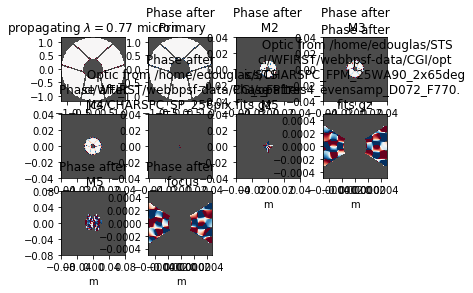

In [ ]:
%matplotlib inline

psf,wf=WFIRSTSPC(npix=64).calcPSF(wavelength=wavelen,display_intermediates=True, return_intermediates=True)

In [ ]:
import logging
logger = logging.getLogger("poppy")
logger.setLevel(logging.DEBUG)


for w in wf:
    print(w.pixelscale)

0.03703125 m / pix
0.03703125 m / pix
0.00031250000038878314 m / pix
0.00031250000038878314 m / pix
0.0003125006011209341 m / pix
0.0003125006011209341 m / pix
0.0003125006011209341 m / pix
3.849988893704971e-06 m / pix
0.0006250021033418255 m / pix
3.849983342974596e-06 m / pix


In [ ]:
test_optsys= WFIRSTSPC()#optsys()
poppy.accel_math._FFTW_AVAILABLE= True
poppy.accel_math._CUDA_AVAILABLE= False
poppy.accel_math._USE_CUDA= False
poppy.accel_math._USE_NUMEXPR=True




print(poppy.accel_math._USE_CUDA,poppy.accel_math._CUDA_AVAILABLE,poppy.accel_math._USE_NUMEXPR,poppy.conf.use_fftw )
test_optsys=WFIRSTSPC(npix=512,ratio=0.25)
#run one test case so FFTW wisdom is cached.
#t1=test_optsys.calcPSF(wavelength=wavelen, display_intermediates=False, return_intermediates=False)
        #run timed test

INFO:Initialized OpticalSystem: unnamed system
DEBUG:Trans: /home/edouglas/STScI/WFIRST/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
DEBUG:OPD: None
INFO:Optic from /home/edouglas/STScI/WFIRST/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits: Loaded amplitude transmission from /home/edouglas/STScI/WFIRST/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
DEBUG:  Looking for 'PUPLSCAL' or 'PIXSCALE' or 'PIXELSCL' in FITS headers to set pixel scale
DEBUG:Trans: /home/edouglas/STScI/WFIRST/webbpsf-data/CGI/optics/CHARSPC_SP_256pix.fits.gz
DEBUG:OPD: None
INFO:Optic from /home/edouglas/STScI/WFIRST/webbpsf-data/CGI/optics/CHARSPC_SP_256pix.fits.gz: Loaded amplitude transmission from /home/edouglas/STScI/WFIRST/webbpsf-data/CGI/optics/CHARSPC_SP_256pix.fits.gz
DEBUG:  Looking for 'PUPLSCAL' or 'PIXSCALE' or 'PIXELSCL' in FITS headers to set pixel scale
DEBUG:Trans: /home/edouglas/STScI/WFIRST/webbpsf-data/CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res4_evensamp_D072_F770.fits.gz


False False True True


In [ ]:
#time = %timeit -o test_optsys.calcPSF(wavelength=wavelen, display_intermediates=False, return_intermediates=False)
psf_timing = %prun -r  -s  tottime test_optsys.calcPSF(wavelength=wavelen, display_intermediates=False, return_intermediates=False)



INFO:Calculating PSF with 1 wavelengths
DEBUG:Already loaded wisdom prior to this calculation, not reloading.
INFO: Propagating wavelength = 7.7e-07 m meters
DEBUG:Padded WF array for oversampling by 4, to (2048, 2048).
DEBUG:Creating input wavefront with wavelength=0.77 microns,npix=512, pixel scale=0.00462890625 m / pix
DEBUG:  Propagating wavefront to Pupil plane: Optic from /home/edouglas/STScI/WFIRST/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits  after distance 0.0 m 
DEBUG:Pixelscales: wave 0.00462890625 m / pix, optic 0.0092578125 m / pix
DEBUG:resampled optic to match wavefront via spline interpolation by a zoom factor of 2
DEBUG:resampled optic shape: (512, 512)   wavefront shape: (2048, 2048)
DEBUG:padded an optic with a 768 x 768 border to optic to match the wavefront
DEBUG:  Multiplied WF by phasor for Pupil plane: Optic from /home/edouglas/STScI/WFIRST/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits 
DEBUG:normalizing at first plane (entrance pupil) to 1.0 total 

DEBUG:using pyfftw FFT of (2048, 2048) array, FFT_direction=forward
DEBUG:    FFT_2D: FFT in 0.064949 s, full function  in 0.075 s
DEBUG:using pyfftw FFT of (2048, 2048) array, FFT_direction=backward
DEBUG:    FFT_2D: FFT in 0.075353 s, full function  in 0.086 s
DEBUG:------ Propagated to plane of type PlaneType.intermediate at z = 2.04e+01 m ------
DEBUG:Pixelscales: wave 3.9062575140116765e-05 m / pix, optic 0.001953125 cm / pix
/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
DEBUG:resampled optic to match wavefront via spline interpolation by a zoom factor of 0.5
DEBUG:resampled optic shape: (128, 128)   wavefront shape: (2048, 2048)
DEBUG:padded an optic with a 960 x 960 border to optic to match the wavefront
DEBUG:  Mul

In [ ]:
#fraunhofer system
osys_fraun = poppy.OpticalSystem(npix=2048,oversample=4)
osys_fraun.add_pupil( poppy.CircularAperture(radius=3))    # pupil radius in meters
osys_fraun.add_detector(pixelscale=0.010, fov_arcsec=2.0)  # image plane coordinates in arcseconds

%timeit psf = osys_fraun.calc_psf(2e-6,display_intermediates=False)# wavelength in microns



INFO:Initialized OpticalSystem: unnamed system
INFO:Added pupil plane: Circle, radius=3.0 m
INFO:Added detector with pixelscale=0.01 and oversampling=4: Detector
INFO:Calculating PSF with 1 wavelengths
DEBUG:Already loaded wisdom prior to this calculation, not reloading.
INFO: Propagating wavelength = 2e-06 m
DEBUG:Creating input wavefront with wavelength=2e-06 m, npix=2048, pixel scale=0.00293 meters/pixel
DEBUG:  Wavefront and optic Circle, radius=3.0 m already at same plane type, no propagation needed.
DEBUG:  Multiplied WF by phasor for Pupil plane: Circle, radius=3.0 m (Analytic)
DEBUG:normalizing at first plane (entrance pupil) to 1.0 total intensity
DEBUG:  Propagating wavefront to Detector plane: Detector (200x200 pixels, 0.01 arcsec / pix). 
DEBUG:MatrixFourierTransform initialized using centering type = ADJUSTABLE
DEBUG:    Propagating w/ MFT: 0.0025 arcsec / pix     fov=29.089 lam/D    npix=800
DEBUG:      MFT method = ADJUSTABLE
DEBUG:Forward MatrixFourierTransform: array s

DEBUG:    Propagating w/ MFT: 0.0025 arcsec / pix     fov=29.089 lam/D    npix=800
DEBUG:      MFT method = ADJUSTABLE
DEBUG:Forward MatrixFourierTransform: array shape (2048, 2048), centering style ADJUSTABLE, output region size 29.08882086657216 in lambda / D units, output array size 800.0 pixels, offset (0, 0)
DEBUG:     Result wavefront: at=after Circle, radius=3.0 m shape=(800, 800) intensity=0.987
INFO:  Calculation completed in 0.659 s
DEBUG:FFTW wisdom saved to /home/edouglas/.astropy/config/poppy_fftw_wisdom.json
INFO:PSF Calculation completed.
INFO:Calculating PSF with 1 wavelengths
DEBUG:Already loaded wisdom prior to this calculation, not reloading.
INFO: Propagating wavelength = 2e-06 m
DEBUG:Creating input wavefront with wavelength=2e-06 m, npix=2048, pixel scale=0.00293 meters/pixel
DEBUG:  Wavefront and optic Circle, radius=3.0 m already at same plane type, no propagation needed.
DEBUG:  Multiplied WF by phasor for Pupil plane: Circle, radius=3.0 m (Analytic)
DEBUG:norm

659 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Benchmark baseline optical system with acceleration

In [ ]:
#from astropy.table import Table
import pandas as pd
pixlist = pd.Series([2**4,2**6,2**7,
                     2**8,2**9,700,
                     #2**10,2**11, #expect tens of minute runtime with these enabled
                    ])


In [ ]:
scenarios=[[False,False,False], #plain numpy
          [False,False,True], #FFTW
          [False,True,False], #numexpr
        [False,True,True], #numexpr, FFT
        [True,True,True], #CUDA, Numexpr, FFTW
          [True,True,False], #CUDA, Numexpr
          ]

In [ ]:
timings={}
import importlib
logger.setLevel(logging.CRITICAL)


for combo in scenarios:
    df = pd.DataFrame(np.zeros([pixlist.size,4]), index=pixlist, columns=["avg",
                                                                          "std",
                                                                         "avg_fraun",
                                                                         "std_fraun",])
    print(combo)
    poppy.accel_math._CUDA_AVAILABLE  = combo[0]
    poppy.accel_math._USE_CUDA= combo[0]
    poppy.accel_math._NUMEXPR_AVAILABLE  = combo[1]
    poppy.accel_math._USE_NUMEXPR=combo[1]
    poppy.accel_math._FFTW_AVAILABLE= combo[2]
    poppy.accel_math._USE_FFTW= combo[2]

    time_fraun=  %timeit -o osys_fraun.calc_psf(wavelen,display_intermediates=False)


    print(poppy.accel_math._USE_CUDA,poppy.accel_math._USE_CUDA,poppy.accel_math._FFTW_AVAILABLE )
    for i,npix in enumerate(pixlist):
        test_optsys=WFIRSTSPC(npix=npix,ratio=0.25)
        #run one test case so FFTW wisdom is cached.
        t1=test_optsys.calcPSF(wavelength=wavelen, display_intermediates=False, return_intermediates=False)
        #run timed test
        time = %timeit -o test_optsys.calcPSF(wavelength=wavelen, display_intermediates=False, return_intermediates=False)

        df.iloc[i]["std"] = time.stdev
        df.iloc[i]["avg"] = time.average
        df.iloc[i]["std_fraun"] = time_fraun.stdev
        df.iloc[i]["avg_fraun"] = time_fraun.average
    outname='cuda'+str(poppy.accel_math._USE_CUDA)+'NumExpr'+str(poppy.accel_math._USE_NUMEXPR)+'FFT'+str(poppy.accel_math._FFTW_AVAILABLE)+'.csv'
    df.to_csv(outname,float_format="%3.3e")
    print(outname)
    psf_timing = %prun -r  -s  tottime test_optsys.calcPSF(display_intermediates=False, return_intermediates=False)
    psf_timing.print_stats()
    

[False, False, False]
1.19 s ± 4.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
False False False


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


113 ms ± 781 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


235 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


644 ms ± 5.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


2.43 s ± 35.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


13.8 s ± 53.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


25.9 s ± 53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
cudaFalseNumExprFalseFFTFalse.csv


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


          76870 function calls (76495 primitive calls) in 25.716 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       19   10.679    0.562   10.679    0.562 accel_math.py:91(_exp)
       58    3.597    0.062    3.597    0.062 {method 'take' of 'numpy.ndarray' objects}
       13    2.859    0.220   11.088    0.853 fresnel.py:55(get_phasor)
        6    1.356    0.226    6.674    1.112 fresnel.py:596(_propagate_ptp)
       19    1.278    0.067    1.280    0.067 fresnel.py:407(pupil_coordinates)
        3    1.208    0.403    2.100    0.700 poppy_core.py:1915(get_phasor)
       13    0.825    0.063    0.825    0.063 {mkl_fft._pydfti.fftn}
        6    0.720    0.120    0.720    0.120 poppy_core.py:594(amplitude)
       17    0.705    0.041   15.373    0.904 poppy_core.py:187(__imul__)
        1    0.388    0.388    0.416    0.416 optics.py:96(get_phasor)
        6    0.386    0.064    0.386    0.064 {mkl_fft._pydfti.ifftn}
 

       19    0.000    0.000    0.000    0.000 card.py:427(comment)
        6    0.000    0.000    0.386    0.064 _numpy_fft.py:870(ifft2)
       61    0.000    0.000    0.000    0.000 util.py:741(_is_int)
       20    0.000    0.000    0.000    0.000 numeric.py:534(asanyarray)
        4    0.000    0.000    0.000    0.000 base.py:241(_has_data)
        1    0.000    0.000    0.000    0.000 {method 'round' of 'numpy.ndarray' objects}
       12    0.000    0.000    0.000    0.000 numbers.py:283(__float__)
        4    0.000    0.000    0.000    0.000 quantity.py:1161(quantity_iter)
        3    0.000    0.000    0.001    0.000 quantity.py:1358(_decompose)
        7    0.000    0.000    0.006    0.001 fresnel.py:96(__init__)
       24    0.000    0.000    0.001    0.000 card.py:203(__str__)
        6    0.000    0.000    0.000    0.000 numeric.py:197(ones_like)
       13    0.000    0.000    0.000    0.000 header.py:815(get)
        6    0.000    0.000    0.000    0.000 interpolation.py:5

1.21 s ± 7.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
False False True


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


118 ms ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


247 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


662 ms ± 4.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


2.59 s ± 42.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


14.5 s ± 58.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


27.3 s ± 119 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
cudaFalseNumExprFalseFFTTrue.csv


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


          77657 function calls (77282 primitive calls) in 27.772 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       19   10.865    0.572   10.865    0.572 accel_math.py:91(_exp)
       77    3.641    0.047    3.641    0.047 {method 'take' of 'numpy.ndarray' objects}
       13    2.911    0.224   11.248    0.865 fresnel.py:55(get_phasor)
       19    1.557    0.082    2.681    0.141 _utils.py:49(_Xfftn)
        6    1.426    0.238    7.919    1.320 fresnel.py:596(_propagate_ptp)
       19    1.305    0.069    1.307    0.069 fresnel.py:407(pupil_coordinates)
        3    1.253    0.418    2.184    0.728 poppy_core.py:1915(get_phasor)
       47    0.858    0.018    0.858    0.018 {method 'copy' of 'numpy.ndarray' objects}
        6    0.753    0.125    0.753    0.125 poppy_core.py:594(amplitude)
       17    0.713    0.042   15.633    0.920 poppy_core.py:187(__imul__)
        1    0.382    0.382    0.411    0.411 optics.py

       19    0.000    0.000    0.000    0.000 {built-in method pyfftw.pyfftw.is_byte_aligned}
        6    0.000    0.000    0.000    0.000 interpolation.py:592(<listcomp>)
       11    0.000    0.000    0.000    0.000 poppy_core.py:613(shape)
       38    0.000    0.000    0.000    0.000 {method 'insert' of 'list' objects}
       74    0.000    0.000    0.000    0.000 {method 'startswith' of 'str' objects}
        7    0.000    0.000    0.005    0.001 fresnel.py:96(__init__)
       59    0.000    0.000    0.000    0.000 image.py:215(header)
        4    0.000    0.000    0.000    0.000 quantity.py:1161(quantity_iter)
       72    0.000    0.000    0.000    0.000 {method 'pop' of 'dict' objects}
        1    0.000    0.000    0.000    0.000 accel_math.py:60(update_math_settings)
        2    0.000    0.000    0.001    0.000 image.py:248(data)
        7    0.000    0.000    0.000    0.000 header.py:1681(_relativeinsert)
        5    0.000    0.000    0.000    0.000 os.py:664(__getitem__

613 ms ± 6.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
False False False


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


148 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


202 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


350 ms ± 6.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


1.03 s ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


6.5 s ± 23.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


12 s ± 43.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
cudaFalseNumExprTrueFFTFalse.csv


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


          78604 function calls (78229 primitive calls) in 12.151 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       58    3.585    0.062    3.585    0.062 {method 'take' of 'numpy.ndarray' objects}
       79    2.367    0.030    2.372    0.030 necompiler.py:734(evaluate)
        3    1.197    0.399    2.091    0.697 poppy_core.py:1915(get_phasor)
        6    0.878    0.146    3.187    0.531 fresnel.py:596(_propagate_ptp)
       13    0.869    0.067    0.869    0.067 {mkl_fft._pydfti.fftn}
        6    0.719    0.120    0.719    0.120 poppy_core.py:594(amplitude)
       17    0.702    0.041    5.526    0.325 poppy_core.py:187(__imul__)
        6    0.387    0.064    0.387    0.064 {mkl_fft._pydfti.ifftn}
       19    0.373    0.020    1.630    0.086 accel_math.py:151(fft_2d)
        6    0.119    0.020    0.119    0.020 {built-in method scipy.ndimage._nd_image.zoom_shift}
       29    0.110    0.004    3.699    0.128 he

       13    0.000    0.000    0.000    0.000 header.py:815(get)
        4    0.000    0.000    0.000    0.000 accel_math.py:70(_float)
        1    0.000    0.000    0.011    0.011 poppy_core.py:255(get_unpadded)
        6    0.000    0.000    0.000    0.000 numeric.py:197(ones_like)
        2    0.000    0.000    0.000    0.000 {built-in method posix.urandom}
        1    0.000    0.000    0.029    0.029 optics.py:399(get_transmission)
        1    0.000    0.000    0.000    0.000 base.py:153(__init__)
       13    0.000    0.000    0.000    0.000 decorators.py:705(__get__)
        1    0.000    0.000    0.000    0.000 warnings.py:35(_formatwarnmsg_impl)
        6    0.000    0.000    0.000    0.000 _ni_support.py:55(_normalize_sequence)
        4    0.000    0.000    0.006    0.002 {method 'sum' of 'numpy.ndarray' objects}
       16    0.000    0.000    0.000    0.000 _methods.py:40(_all)
        2    0.000    0.000    0.000    0.000 header.py:75(__init__)
        2    0.000    0.00

/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


154 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


220 ms ± 5.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


380 ms ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


1.13 s ± 26.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


7.35 s ± 25.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


13.2 s ± 264 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
cudaFalseNumExprTrueFFTTrue.csv


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


          79391 function calls (79016 primitive calls) in 13.610 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       77    3.599    0.047    3.599    0.047 {method 'take' of 'numpy.ndarray' objects}
       79    2.355    0.030    2.360    0.030 necompiler.py:734(evaluate)
       19    1.506    0.079    2.585    0.136 _utils.py:49(_Xfftn)
        3    1.201    0.400    2.108    0.703 poppy_core.py:1915(get_phasor)
        6    0.888    0.148    4.141    0.690 fresnel.py:596(_propagate_ptp)
       47    0.818    0.017    0.818    0.017 {method 'copy' of 'numpy.ndarray' objects}
        6    0.733    0.122    0.733    0.122 poppy_core.py:594(amplitude)
       17    0.704    0.041    5.541    0.326 poppy_core.py:187(__imul__)
       19    0.373    0.020    3.050    0.161 accel_math.py:151(fft_2d)
       19    0.184    0.010    0.589    0.031 _utils.py:76(_Xfftn)
        6    0.119    0.020    0.119    0.020 {built-in method 

      230    0.000    0.000    0.000    0.000 {method 'pop' of 'dict' objects}
       83    0.000    0.000    0.000    0.000 header.py:1772(_haswildcard)
       64    0.000    0.000    0.000    0.000 header.py:1795(_set_slice)
       98    0.000    0.000    0.000    0.000 {method 'values' of 'mappingproxy' objects}
      162    0.000    0.000    0.000    0.000 core.py:279(get_current_unit_registry)
      194    0.000    0.000    0.000    0.000 inspect.py:2785(parameters)
        1    0.000    0.000    0.002    0.002 image.py:38(__init__)
        2    0.000    0.000    0.001    0.000 image.py:310(update_header)
       31    0.000    0.000    0.001    0.000 card.py:274(value)
       13    0.000    0.000    0.091    0.007 _methods.py:25(_amax)
       12    0.000    0.000    0.001    0.000 quantity_helper.py:117(helper_sqrt)
       48    0.000    0.000    0.000    0.000 quantity_helper.py:113(helper_invariant)
       49    0.000    0.000    0.000    0.000 inspect.py:2569(__init__)
       9

640 ms ± 5.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
True True True


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


158 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


237 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


417 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


1.1 s ± 5.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


4.56 s ± 71.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


11 s ± 113 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
cudaTrueNumExprTrueFFTTrue.csv


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


          84612 function calls (84199 primitive calls) in 11.129 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       58    3.625    0.062    3.625    0.062 {method 'take' of 'numpy.ndarray' objects}
       79    1.319    0.017    1.323    0.017 necompiler.py:734(evaluate)
        3    1.228    0.409    2.142    0.714 poppy_core.py:1915(get_phasor)
      109    1.146    0.011    1.146    0.011 driver.py:284(safe_cuda_api_call)
        6    0.924    0.154    2.625    0.437 fresnel.py:596(_propagate_ptp)
        6    0.738    0.123    0.738    0.123 poppy_core.py:594(amplitude)
       17    0.724    0.043    4.948    0.291 poppy_core.py:187(__imul__)
       19    0.381    0.020    1.547    0.081 accel_math.py:151(fft_2d)
        6    0.120    0.020    0.120    0.020 {built-in method scipy.ndimage._nd_image.zoom_shift}
      109    0.113    0.001    0.113    0.001 {method 'reduce' of 'numpy.ufunc' objects}
       29    0.112

        6    0.000    0.000    0.396    0.066 fresnel.py:357(_inv_fft)
      177    0.000    0.000    0.000    0.000 core.py:1642(decompose)
       38    0.000    0.000    0.000    0.000 <string>:12(__new__)
       38    0.000    0.000    0.000    0.000 driver.py:1003(own)
       38    0.000    0.000    0.000    0.000 devicearray.py:280(is_f_contiguous)
       19    0.000    0.000    0.000    0.000 {built-in method numba.mviewbuf.memoryview_get_extents}
       76    0.000    0.000    0.002    0.000 _methods.py:34(_prod)
      133    0.000    0.000    0.000    0.000 driver.py:1545(is_device_memory)
       84    0.000    0.000    0.000    0.000 {method 'rpartition' of 'str' objects}
       76    0.000    0.000    0.000    0.000 threadlocal.py:13(stack)
        6    0.000    0.000    0.000    0.000 poppy_core.py:2157(__str__)
       83    0.000    0.000    0.000    0.000 header.py:1772(_haswildcard)
      105    0.000    0.000    0.001    0.000 core.py:1983(<listcomp>)
        6    0.000 

643 ms ± 8.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
True True False


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


166 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


244 ms ± 7.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


428 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


1.1 s ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


4.63 s ± 83.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


10.9 s ± 66.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
cudaTrueNumExprTrueFFTFalse.csv


/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


          84395 function calls (83982 primitive calls) in 10.872 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       58    3.562    0.061    3.562    0.061 {method 'take' of 'numpy.ndarray' objects}
       79    1.253    0.016    1.257    0.016 necompiler.py:734(evaluate)
        3    1.209    0.403    2.111    0.704 poppy_core.py:1915(get_phasor)
      109    1.123    0.010    1.123    0.010 driver.py:284(safe_cuda_api_call)
        6    0.895    0.149    2.818    0.470 fresnel.py:596(_propagate_ptp)
        6    0.731    0.122    0.731    0.122 poppy_core.py:594(amplitude)
       17    0.708    0.042    4.838    0.285 poppy_core.py:187(__imul__)
       19    0.367    0.019    1.510    0.079 accel_math.py:151(fft_2d)
        6    0.117    0.019    0.117    0.019 {built-in method scipy.ndimage._nd_image.zoom_shift}
      109    0.113    0.001    0.113    0.001 {method 'reduce' of 'numpy.ufunc' objects}
       29    0.111

       51    0.000    0.000    0.000    0.000 {built-in method __new__ of type object at 0x7f49bc204120}
       38    0.000    0.000    0.000    0.000 devices.py:190(get_context)
       38    0.000    0.000    0.000    0.000 threadlocal.py:37(__bool__)
       76    0.000    0.000    0.000    0.000 driver.py:1116(__getattr__)
       90    0.000    0.000    0.000    0.000 {method 'rsplit' of 'str' objects}
       66    0.000    0.000    0.000    0.000 card.py:510(is_blank)
       48    0.000    0.000    0.000    0.000 quantity_helper.py:113(helper_invariant)
       16    0.000    0.000    0.001    0.000 core.py:822(_apply_equivalencies)
       96    0.000    0.000    0.000    0.000 {method 'items' of 'mappingproxy' objects}
       76    0.000    0.000    0.000    0.000 driver.py:1556(require_device_memory)
        1    0.000    0.000    0.002    0.002 image.py:38(__init__)
        8    0.000    0.000    7.468    0.934 decorators.py:826(propagate_fresnel)
       12    0.000    0.000    0.

/home/edouglas/anaconda3/envs/idp/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


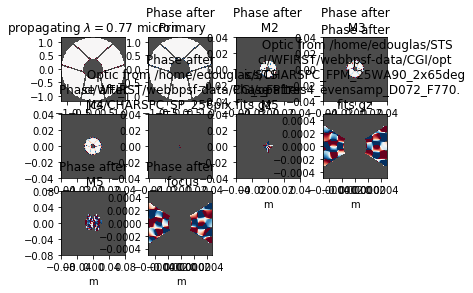

In [ ]:
#make sure system not broken
psf,wf=WFIRSTSPC(npix=64).calcPSF(wavelength=wavelen,display_intermediates=True, return_intermediates=True)



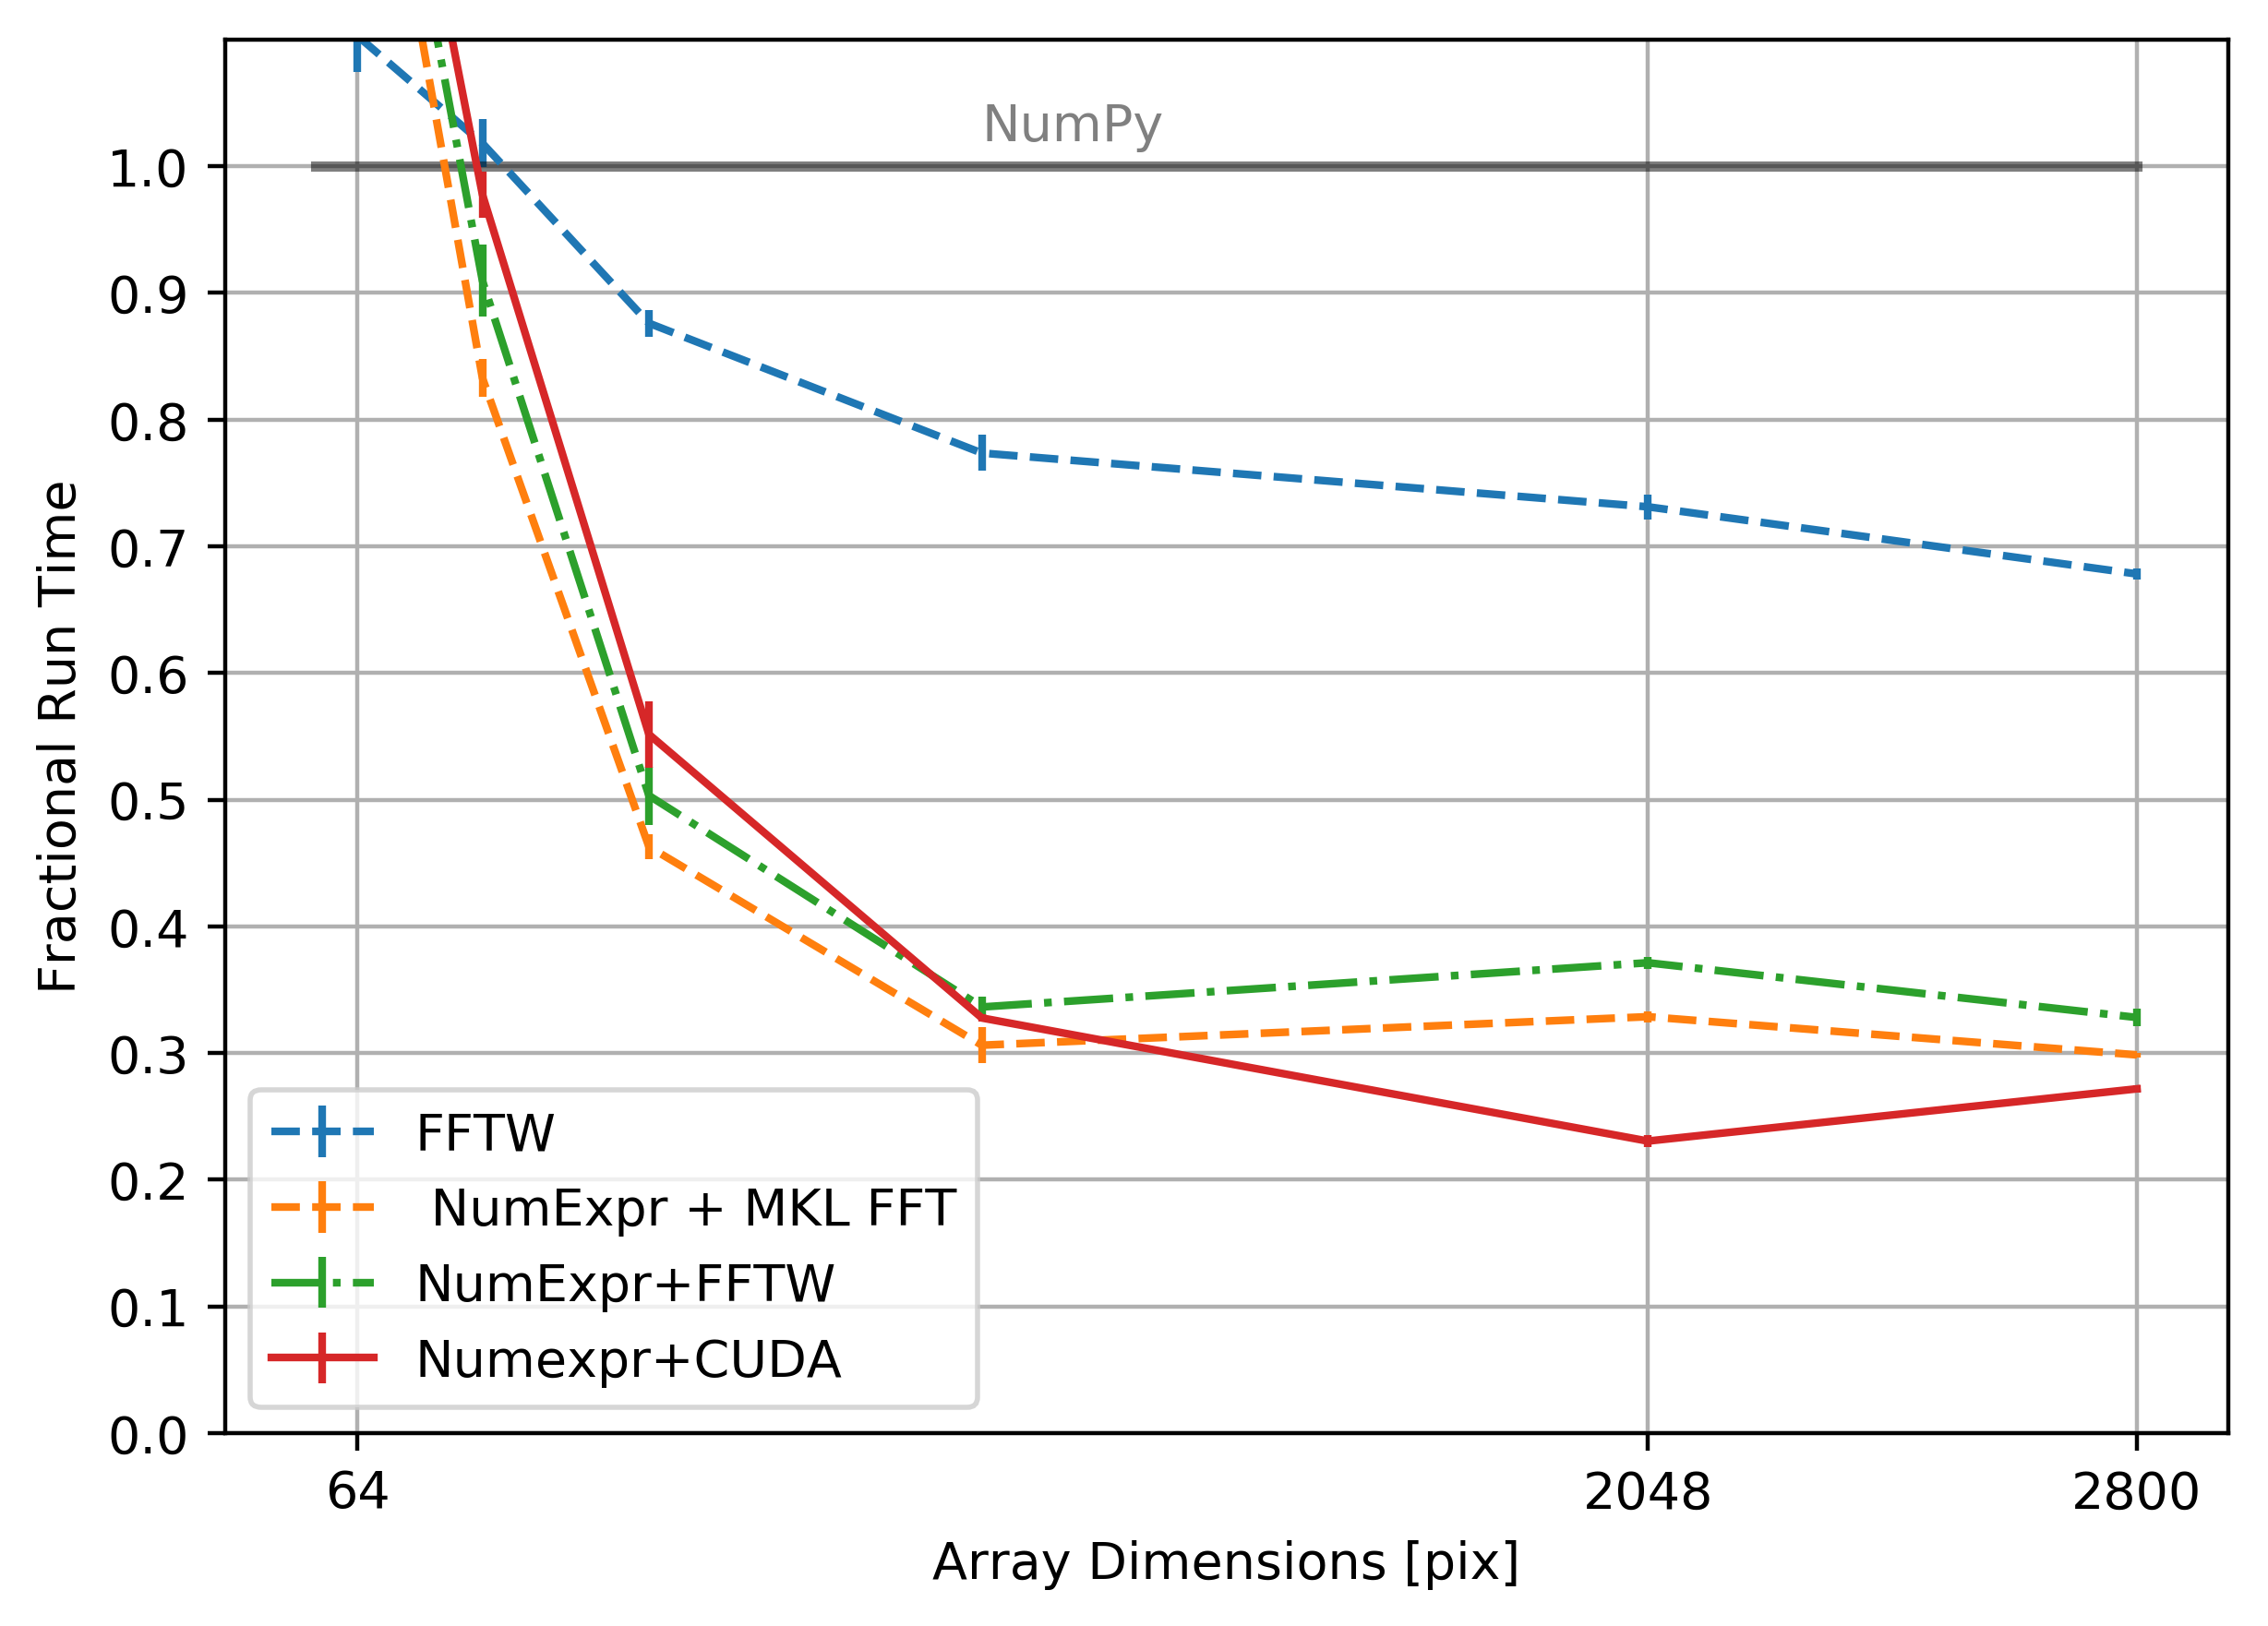

In [42]:
plt.figure(dpi=400, figsize=[7,5])
ax=plt.subplot(111)

y=pd.read_csv("noMKL"+'cuda'+str(False)+'NumExpr'+str(False)+'FFT'+str(False)+'.csv',index_col=0)


y_MKL=pd.read_csv("cuda"+str(False)+'NumExpr'+str(True)+'FFT'+str(False)+'.csv',index_col=0)


y_FFTW=pd.read_csv(""+'cuda'+str(False)+'NumExpr'+str(False)+'FFT'+str(True)+'.csv',index_col=0)

ax.errorbar(pixlist,y_FFTW["avg"]/y["avg"],
            yerr=y_FFTW["avg"]/y["avg"]*np.sqrt((y_FFTW["std"]/y_FFTW["avg"])**2+(y["std"]/y["avg"])**2),
            label="FFTW",linestyle="--" )
ax.errorbar(pixlist,y_MKL["avg"]/y["avg"],
            yerr=y_MKL["avg"]/y["avg"]*np.sqrt((y_MKL["std"]/y_MKL["avg"])**2+(y["std"]/y["avg"])**2),
            label=" NumExpr + MKL FFT",linestyle="--" )

y_numexpr=pd.read_csv(""+'cuda'+str(False)+'NumExpr'+str(True)+'FFT'+str(True)+'.csv',index_col=0)

ax.errorbar(pixlist,y_numexpr["avg"]/y["avg"],
            yerr=y_numexpr["avg"]/y["avg"]*np.sqrt((y_numexpr["std"]/y_numexpr["avg"])**2+(y["std"]/y["avg"])**2),
            label="NumExpr+FFTW",linestyle="-." )

y_all=pd.read_csv(""+'cuda'+str(True)+'NumExpr'+str(True)+'FFT'+str(True)+'.csv',index_col=0)

ax.errorbar(pixlist,y_all["avg"]/y["avg"],
            yerr=y_all["avg"]/y["avg"]*np.sqrt((y_all["std"]/y_all["avg"])**2+(y["std"]/y["avg"])**2),

            label="Numexpr+CUDA",  )


ax.plot([0,np.max(pixlist)],[1,1],linewidth=2,alpha=.5,color="black")
ax.text(256,1.02,"NumPy",color="gray")
#plt.xscale("log")
ax.set_xticks([pixlist[0]]+list(pixlist[4:]))
#ax.set_xticks(range(len(pixlist)))
ax.set_xticklabels(np.int_(ax.get_xticks()/test_optsys.beam_ratio))
ax.set_yticks(np.arange(0,1.1,.1))
ax.set_ylabel("Fractional Run Time")
plt.legend()
plt.grid()
plt.xlabel("Array Dimensions [pix]")
plt.ylim([0,1.1])
#plt.yscale("log")
plt.savefig("benchmarks%icores.pdf"%(ne.ncores),bbox_inches="tight")


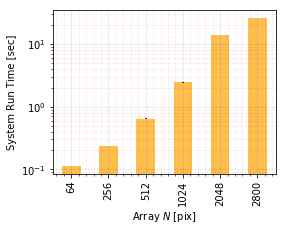

In [ ]:
plt.figure(figsize=[4,3])
ax=plt.subplot(111)

ticks=np.int_(pixlist*4)
y=pd.read_csv('cuda'+str(False)+'NumExpr'+str(False)+'FFT'+str(False)+'.csv',
              index_col=0)

y["avg"].plot.bar(yerr=y["std"],
                       #ticks=ticks,
                  label="NumPy",color="orange",#,linestyle="--",
                   alpha=.7,ax=ax)

#ax.text(256,1.02,"NumPy",color="gray")
ax.set_ylabel("System Run Time [sec]")
#plt.legend()
plt.minorticks_on()

plt.grid(b=True, which='major', color='b', linestyle='-',alpha=.1)

plt.grid(b=True, which='minor', color='r', linestyle='--',alpha=.1)
plt.xlabel("Array $N$ [pix]")
#plt.yscale("log")
plt.yscale("log")
ax.set_xticklabels(ticks)


plt.savefig("NumPy_runtime%icores.pdf"%(ne.ncores),bbox_inches="tight")

In [38]:
#print LaTeX table of Numpy Results:
df=pd.read_csv('cudaFalseNumExprFalseFFTFalse.csv',index_col=0)
df.drop(df.columns[[2,3]], axis=1, inplace=True)
df.index =df.index*4
x=df.to_latex()
print(x)

\begin{tabular}{lrr}
\toprule
{} &      avg &       std \\
\midrule
64   &   0.1134 &  0.000781 \\
256  &   0.2351 &  0.001197 \\
512  &   0.6438 &  0.005862 \\
1024 &   2.4280 &  0.035450 \\
2048 &  13.8400 &  0.053100 \\
2800 &  25.9100 &  0.053010 \\
\bottomrule
\end{tabular}



### where's the remaining bottleneck?

NumExpr evaluations still dominate

In [41]:
psf_timing = %prun -r  -s  tottime  WFIRSTSPC(npix=1024,ratio=0.25).calcPSF(display_intermediates=False, return_intermediates=False)
psf_timing.print_stats()

          108015 function calls (107209 primitive calls) in 18.003 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      261    4.880    0.019    4.882    0.019 driver.py:284(safe_cuda_api_call)
       80    4.573    0.057    4.577    0.057 necompiler.py:734(evaluate)
        6    1.937    0.323    5.902    0.984 fresnel.py:596(_propagate_ptp)
        3    1.739    0.580    3.095    1.032 poppy_core.py:1915(get_phasor)
       17    1.428    0.084    8.374    0.493 poppy_core.py:187(__imul__)
        4    1.075    0.269    1.075    0.269 poppy_core.py:594(amplitude)
       19    0.839    0.044    3.329    0.175 accel_math.py:151(fft_2d)
        4    0.224    0.056    0.224    0.056 {built-in method scipy.ndimage._nd_image.zoom_shift}
      167    0.220    0.001    0.220    0.001 {method 'reduce' of 'numpy.ufunc' objects}
     60/7    0.157    0.003   17.958    2.565 utils.py:1279(unit_check_wrapper)
    23/17    0.141    0.0

   145/87    0.000    0.000    0.000    0.000 abstract.py:110(__hash__)
      105    0.000    0.000    0.000    0.000 dummyarray.py:30(__init__)
      683    0.000    0.000    0.000    0.000 core.py:2024(powers)
       99    0.000    0.000    0.004    0.000 core.py:639(__pow__)
       97    0.000    0.000    0.001    0.000 devices.py:190(get_context)
       87    0.000    0.000    0.000    0.000 core.py:220(equivalencies)
      344    0.000    0.000    0.000    0.000 dummyarray.py:118(<genexpr>)
       64    0.000    0.000    0.000    0.000 misc.py:39(isiterable)
       58    0.000    0.000    0.000    0.000 compiler.py:270(copy)
       64    0.000    0.000    0.009    0.000 header.py:152(__setitem__)
     1256    0.000    0.000    0.000    0.000 inspect.py:2480(name)
       19    0.000    0.000    0.000    0.000 api.py:109(_maybe_transpose)
       18    0.000    0.000    0.000    0.000 quantity_helper.py:652(check_output)
       29    0.000    0.000    0.001    0.000 compiler.py:715(c

        3    0.000    0.000    1.753    0.584 decorators.py:826(_propagate_wts)
       29    0.000    0.000    0.000    0.000 abstract.py:85(__init__)
        4    0.000    0.000    0.000    0.000 accel_math.py:70(_float)
        3    0.000    0.000    0.001    0.000 header.py:392(fromfile)
        3    0.000    0.000    0.009    0.003 convenience.py:945(_getext)
       24    0.000    0.000    0.001    0.000 card.py:203(__str__)
        2    0.000    0.000    0.002    0.001 util.py:554(_array_from_file)
        3    0.000    0.000    0.000    0.000 parse.py:359(urlparse)
       76    0.000    0.000    0.000    0.000 {function HDUList.__getitem__ at 0x7f49799416a8}
       16    0.000    0.000    0.000    0.000 {method 'index' of 'list' objects}
        4    0.000    0.000    0.004    0.001 image.py:956(__init__)
        1    0.000    0.000    0.022    0.022 poppy_core.py:255(get_unpadded)
        4    0.000    0.000    0.016    0.004 {method 'sum' of 'numpy.ndarray' objects}
       21  

## Talbot Effect Illustration

In [ ]:
import poppy
import astropy.units as u
sineWFE=poppy.wfe.SineWaveWFE(spatialfreq=500,amplitude=5e-9)
wf_f = poppy.fresnel.FresnelWavefront(beam_radius=2*u.cm,wavelength=0.5*u.um,npix=256,oversample=8)
wf_f*=sineWFE
Z_t=2*((1/sineWFE.sine_spatial_freq))**2/wf_f.wavelength
       
       
wf_f *= poppy.CircularAperture(radius=wf_f.diam/2)
wf_f.propagate_fresnel(Z_t/10000.)


plt.figure(figsize=[8,4])
ax=wf_f.display(what="both",imagecrop=0.05,colorbar=True)
plt.suptitle("d=%.2f$Z_T$"%(wf_f.z/Z_t).decompose())



max_phase=6.28*(sineWFE.sine_amplitude/wf_f.wavelength).decompose()
amp_min=0.95
ax[0].images[0].set_clim(amp_min,1)
ax[1].images[0].set_clim(-max_phase,max_phase)
ax[1].images[0].set_cmap(plt.cm.magma)

plt.tight_layout()
plt.savefig("zt0.pdf",bbox_inches="tight")



plt.figure(figsize=[8,4])

wf_f.propagate_fresnel(Z_t*.05-wf_f.z)
ax=wf_f.display(what="both",imagecrop=0.05,colorbar=True)
ax[0].images[0].set_clim(amp_min,1)

ax[1].images[0].set_clim(-max_phase,max_phase)
ax[1].images[0].set_cmap(plt.cm.magma)
plt.suptitle("d=%.2f$Z_T$"%(wf_f.z/Z_t).decompose())

plt.tight_layout()
plt.savefig("zt1.pdf",bbox_inches="tight")


wf_f.propagate_fresnel(Z_t*.25-wf_f.z)
plt.figure(figsize=[8,4])
ax=wf_f.display(what="both",imagecrop=0.05,colorbar=True)
ax[0].images[0].set_clim(amp_min,1)

ax[1].images[0].set_clim(-max_phase,max_phase)
ax[1].images[0].set_cmap(plt.cm.magma)
plt.suptitle([(wf_f.z/Z_t).decompose(),np.std(wf_f.amplitude[wf_f.amplitude>1e-9])])
plt.tight_layout()


plt.suptitle("d=%.2f$Z_T$"%(wf_f.z/Z_t).decompose())



plt.tight_layout()
plt.savefig("zt2.pdf",bbox_inches="tight")
print(Z_t.decompose())